# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo -o dropout

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=5)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'
    dropout    <- as.data.frame(t(dropout))

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts,
         dropout=dropout)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts
dropout <- sim$dropout

## Generate AnnData objects and analyze in Scanpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
import pandas as pd
import scipy as sp
from dca.api import dca, normalize

from sklearn.metrics import silhouette_score

sc.settings.set_figure_params(dpi=120)

Using TensorFlow backend.


In [4]:
sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw.obs_names = cellinfo.Cell
sim_raw.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw, min_counts=1)

# remove zero-genes from dropout data frame too
dropout_gt = dropout.loc[:, sim_raw.var_names].values

sim_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true.obs_names = cellinfo.Cell
sim_true.var_names = geneinfo.Gene
sim_true = sim_true[:, sim_raw.var_names].copy()
sim_true

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_per_cell(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

sim_true_norm = sim_true.copy()
sc.pp.normalize_per_cell(sim_true_norm)
sc.pp.log1p(sim_true_norm)
sc.pp.pca(sim_true_norm)

print(dropout_gt[:10, :10])
print(sim_raw)
print(sim_true)

[[0 1 1 0 1 1 0 1 1 1]
 [1 1 1 1 1 0 1 1 0 1]
 [1 0 1 0 0 0 1 1 1 0]
 [1 1 1 0 1 0 0 1 0 1]
 [1 1 1 0 1 0 0 0 1 1]
 [1 1 1 1 0 0 0 1 1 0]
 [1 1 1 1 1 0 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 0 1 1 1]
 [1 1 1 0 1 0 1 1 1 1]]
AnnData object with n_obs × n_vars = 2000 × 197 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
AnnData object with n_obs × n_vars = 2000 × 197 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'


## Denoise simulated data

In [5]:
%%time

dca_zinb = dca(sim_raw, threads=1, copy=True, log1p=False, return_info=True, verbose=False)

dca_zinb_norm = dca_zinb.copy()
sc.pp.normalize_per_cell(dca_zinb_norm)
sc.pp.log1p(dca_zinb_norm)
sc.pp.pca(dca_zinb_norm)

dca: Successfully preprocessed 197 genes and 2000 cells.
dca: Calculating reconstructions...
CPU times: user 31.2 s, sys: 296 ms, total: 31.5 s
Wall time: 31.5 s


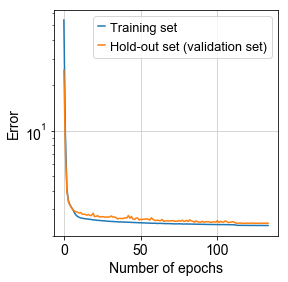

In [6]:
valloss = dca_zinb.uns['dca_loss_history']['val_loss']
loss = dca_zinb.uns['dca_loss_history']['loss']
i = range(len(loss))

f, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(i, loss, i, valloss)
ax.semilogy()
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Error')
plt.legend(['Training set', 'Hold-out set (validation set)'])

In [7]:
dca_mse = dca(sim_raw, ae_type='normal', threads=1, copy=True, normalize_per_cell=False, scale=False,
              training_kwds={'use_raw_as_output': False})

dca_mse.X = np.exp(dca_mse.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 197 genes and 2000 cells.
dca: Calculating reconstructions...


In [8]:
dca_mse_norm = dca_mse.copy()

sc.pp.normalize_per_cell(dca_mse_norm)
sc.pp.log1p(dca_mse_norm)
sc.pp.pca(dca_mse_norm)

... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical


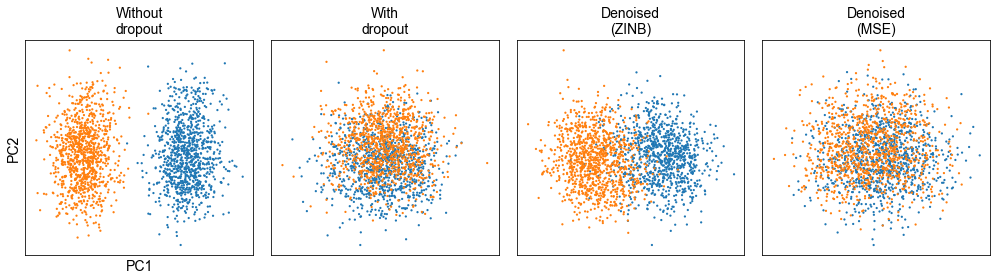

In [9]:
adatas = [sim_true_norm, sim_raw_norm, dca_zinb_norm, dca_mse_norm]
adata_labels = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas), figsize=(14,4))

for i, (lbl, ad, ax) in enumerate(zip(adata_labels, adatas, axs)):
    sc.pl.pca_scatter(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()
#plt.savefig('two-group-pca.pdf')

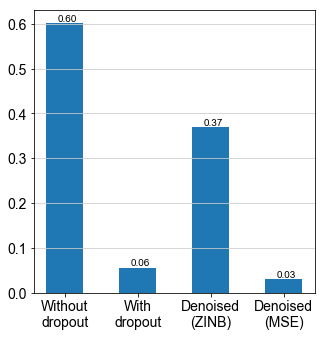

In [10]:
sils = np.array([silhouette_score(ad.obsm.X_pca[:, :2], 
                 ad.obs.Group) for ad in adatas])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils, width=width)
ax.set_xticklabels([''] + adata_labels)

for x, t in zip(x_pos, sils):
    ax.text(x-1, t+0.005, '%.2f' % t)

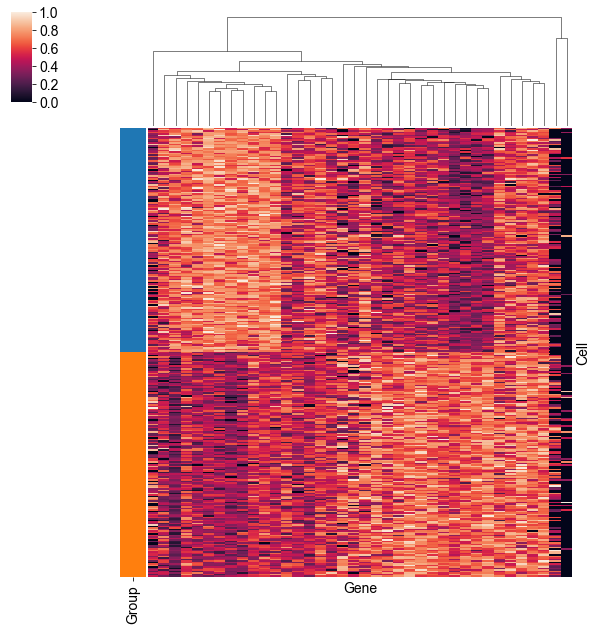

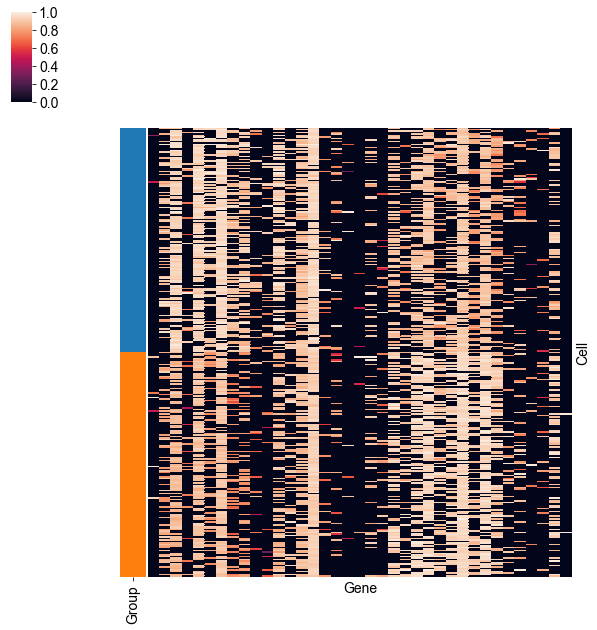

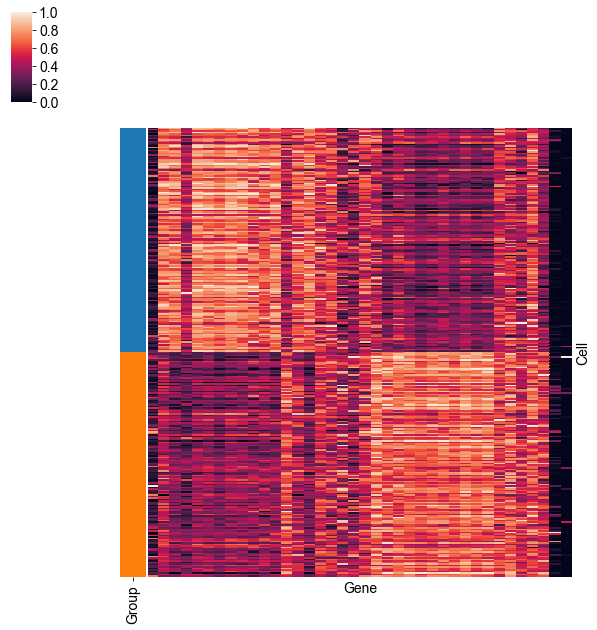

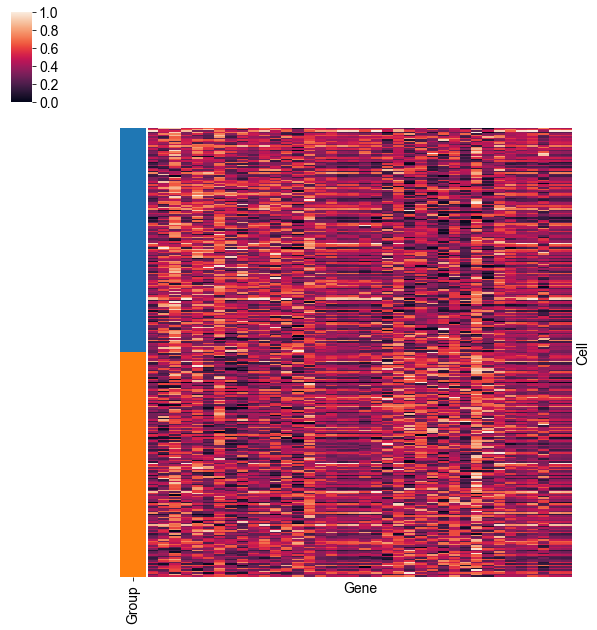

In [11]:
de_genes = np.where(sim_true_norm.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)[0]

obs_idx = np.random.choice(list(range(sim_raw_norm.n_obs)), 300, replace=False)
idx = np.argsort(sim_true_norm.obs.Group.values[obs_idx])
obs_idx = obs_idx[idx]

ax = sc.pl.clustermap(sim_true_norm[:, de_genes][obs_idx, :], 'Group', use_raw=False,
                     standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)
ax.ax_row_dendrogram.set_visible(False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps easily comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sc.pp.filter_genes(sim_raw_norm[:, de_genes][obs_idx, :], min_counts=1, copy=True), 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm[:, de_genes][obs_idx, :], 'Group', use_raw=False, 
                 standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm[:, de_genes][obs_idx, :], 'Group', use_raw=False, 
                 standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

## Comparison of ZINB, NB and MSE models

In [12]:
dca_nb = dca(sim_raw, ae_type='nb-conddisp', threads=1, copy=True, log1p=False)

dca: Successfully preprocessed 197 genes and 2000 cells.
dca: Calculating reconstructions...


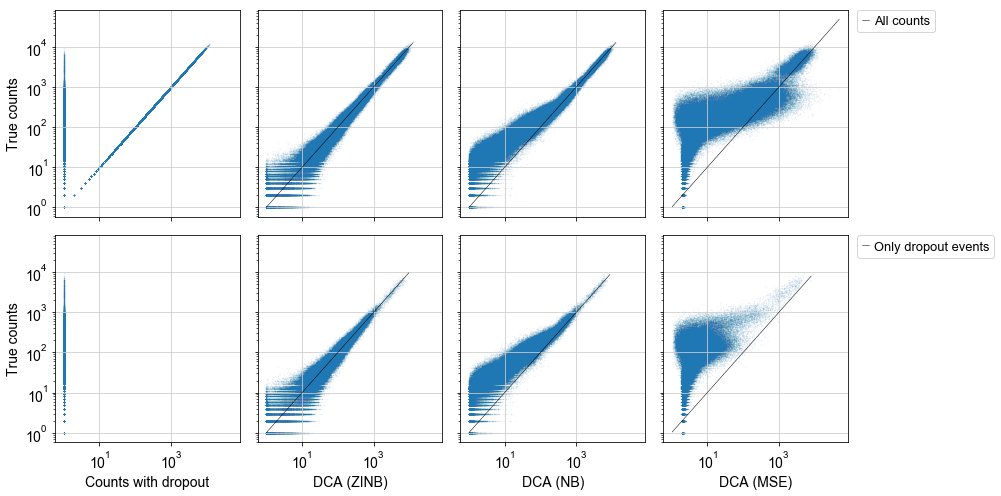

In [13]:
f, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14,7))

adatas_raw = [sim_raw, dca_zinb, dca_nb, dca_mse]
adata_raw_labels = ['Counts with dropout', 'DCA (ZINB)', 'DCA (NB)', 'DCA (MSE)']
true_counts = sim_true.X.flatten()+1

for i, (ax, ad, lbl) in enumerate(zip(axes[0], adatas_raw, adata_raw_labels)):
    x = ad.X.flatten()+1
    y = true_counts
    ax.scatter(x, y, s=0.1, alpha=0.1)
    if i == 0: ax.set_ylabel('True counts')
    else: ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)
        
    ax.loglog()

ax.legend(['All counts'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

true_dropout = true_counts[dropout_gt.flatten()==1]
for i, (ax, ad, lbl) in enumerate(zip(axes[1], adatas_raw, adata_raw_labels)):
    x = ad.X[dropout_gt==1]+1
    y = true_dropout
    ax.scatter(x, y, s=0.1, alpha=0.1)

    if i==0: ax.set_ylabel('True counts')
    else: ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)

    ax.loglog()
    ax.set_xlabel(lbl)

ax.legend(['Only dropout events'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.tight_layout()

## Simulate six groups

In [14]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=3)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

In [15]:
sim_raw6 = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw6.obs_names = cellinfo.Cell
sim_raw6.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw6, min_counts=1)

sim_true6 = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true6.obs_names = cellinfo.Cell
sim_true6.var_names = geneinfo.Gene
sim_true6 = sim_true6[:, sim_raw6.var_names].copy()
sim_true6

sim_raw_norm6 = sim_raw6.copy()
sc.pp.normalize_per_cell(sim_raw_norm6)
sc.pp.log1p(sim_raw_norm6)
sc.pp.pca(sim_raw_norm6)
sc.tl.tsne(sim_raw_norm6)

sim_true_norm6 = sim_true6.copy()
sc.pp.normalize_per_cell(sim_true_norm6)
sc.pp.log1p(sim_true_norm6)
sc.pp.pca(sim_true_norm6)
sc.tl.tsne(sim_true_norm6)

print(sim_raw6)
print(sim_true6)

AnnData object with n_obs × n_vars = 2000 × 199 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
AnnData object with n_obs × n_vars = 2000 × 199 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'


## Denoise simulated data

In [16]:
%%time
dca_zinb6 = dca(sim_raw6, threads=1, copy=True, log1p=False)

dca: Successfully preprocessed 199 genes and 2000 cells.
dca: Calculating reconstructions...
CPU times: user 26.4 s, sys: 262 ms, total: 26.6 s
Wall time: 26.7 s


In [17]:
dca_zinb_norm6 = dca_zinb6.copy()
sc.pp.normalize_per_cell(dca_zinb_norm6)
sc.pp.log1p(dca_zinb_norm6)
sc.pp.pca(dca_zinb_norm6)
sc.tl.tsne(dca_zinb_norm6)

In [18]:
dca_mse6 = dca(sim_raw6, ae_type='normal', threads=1, copy=True, 
              training_kwds={'use_raw_as_output': False}, normalize_per_cell=False, scale=False)

dca_mse_norm6 = dca_mse6.copy()
sc.pp.normalize_per_cell(dca_mse_norm6)
sc.pp.pca(dca_mse_norm6)
sc.tl.tsne(dca_mse_norm6)

dca_mse6.X = np.exp(dca_mse6.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 199 genes and 2000 cells.
dca: Calculating reconstructions...


... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical
... storing 'Batch' as categorical
... storing 'Group' as categorical


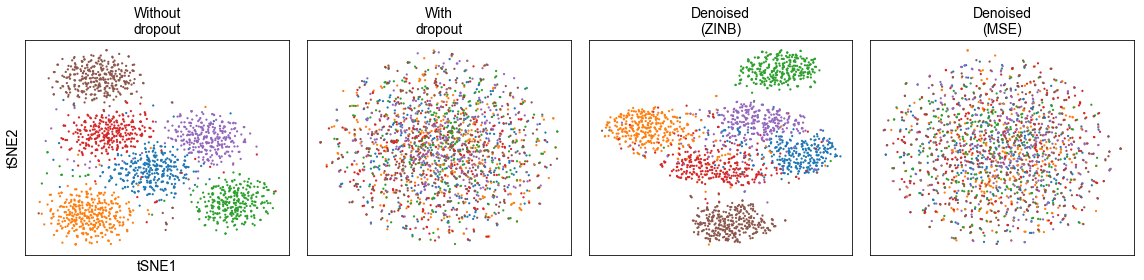

In [19]:
adatas6 = [sim_true_norm6, sim_raw_norm6, dca_zinb_norm6, dca_mse_norm6]
adata_labels6 = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas6), figsize=(16,4))
for i, (lbl, ad, ax) in enumerate(zip(adata_labels6, adatas6, axs)):
    sc.pl.tsne(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()

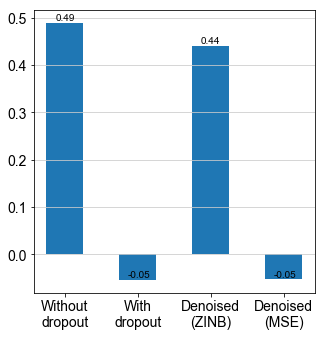

In [20]:
from sklearn.metrics import silhouette_score
sils6 = np.array([silhouette_score(ad.obsm.X_tsne, 
                 ad.obs.Group) for ad in adatas6])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils6, width=width)
ax.set_xticklabels([''] + adata_labels6)

for x, t in zip(x_pos, sils6):
    ax.text(x-1.3, t+0.005, '%.2f' % t)

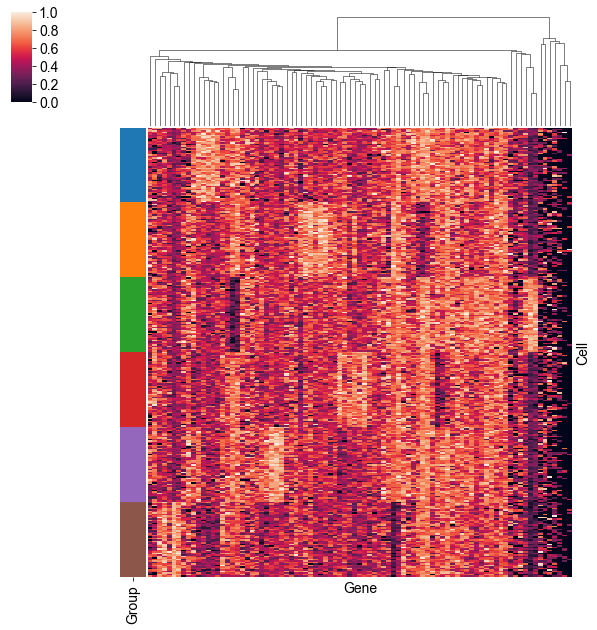

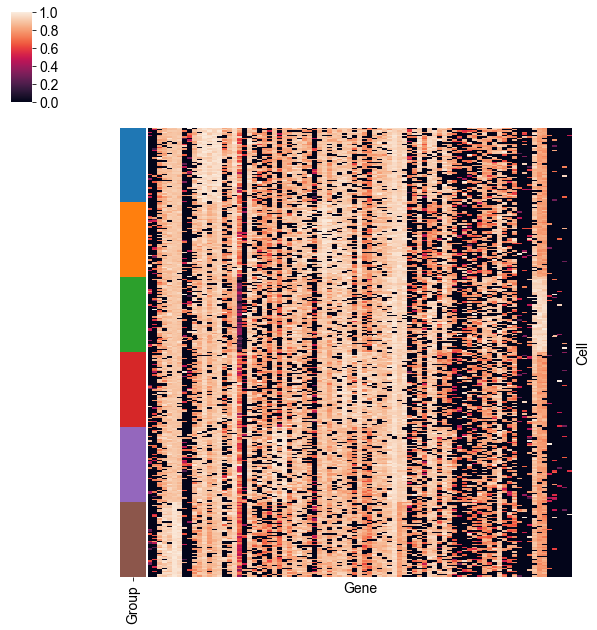

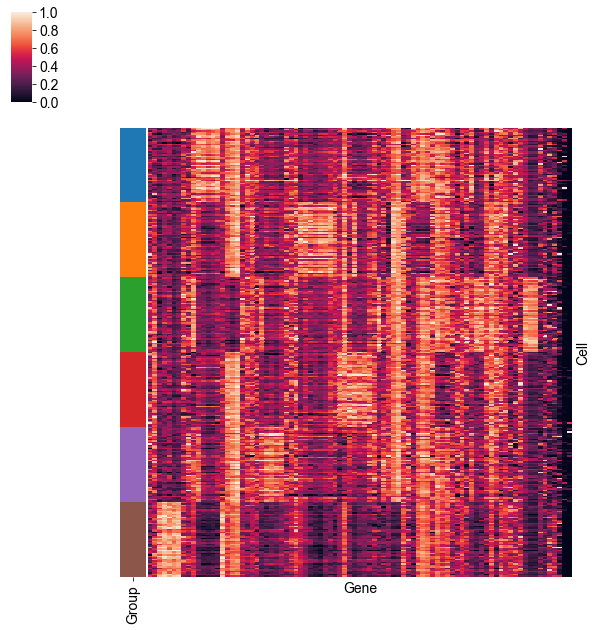

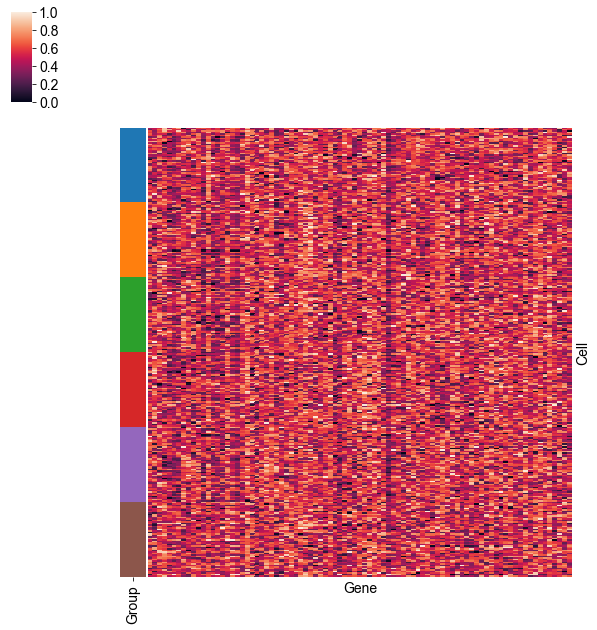

In [21]:
de_genes = np.where(sim_true_norm6.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)[0]

# stratified sampling
total_samples = 300
total_cats = len(sim_true_norm6.obs.Group.cat.categories)
obs_idx = []
for c in sim_true_norm6.obs.Group.cat.categories:
    obs_idx.extend(list(np.random.choice(list(np.where(sim_true_norm6.obs.Group == c)[0]), 
                                         total_samples//total_cats, 
                                         replace=False)))

ax = sc.pl.clustermap(sim_true_norm6[:, de_genes][obs_idx, :], 'Group', use_raw=False,
                     standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sc.pp.filter_genes(sim_raw_norm6[:, de_genes][obs_idx, :], min_counts=1, copy=True), 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm6[:, de_genes][obs_idx, :], 'Group', use_raw=False, 
                 standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm6[:, de_genes][obs_idx, :], 'Group', use_raw=False, 
                 standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)